In [1]:
import torch
import cv2
import torchvision.transforms as transforms
from unprocess import *
from process import *
import matplotlib.pyplot as plt
# from PIL import Image
import numpy as np

In [2]:
# Read the image and convert to RGB
image = cv2.imread("/home/sougato97/Thesis/datasets/LOLdataset/RAW_NoNoiseHigh/high/6.png")

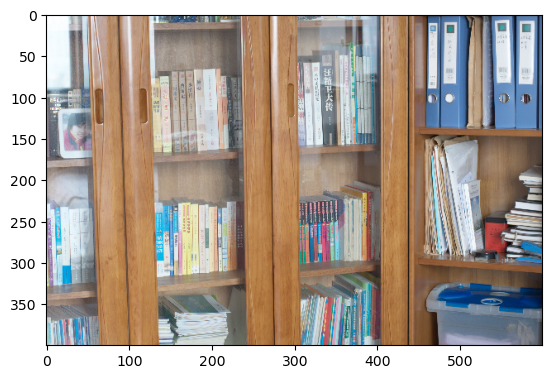

In [3]:
temp = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(temp)

In [4]:
temp.shape

(400, 600, 3)

Convert the image to a tensor

In [5]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB color space

In [6]:
# Define the transform
transform = transforms.ToTensor()

In [7]:
# Convert the image to tensor
tensor = transform(image)

In [8]:
# Print the shape
print(image.shape)

(400, 600, 3)


Get the unprocesses image

In [9]:
def unprocess_no_mosaic(image):
  """Unprocesses an image from sRGB to realistic raw data."""

  # Randomly creates image metadata.
  rgb2cam = random_ccm()
  cam2rgb = torch.inverse(rgb2cam)
  rgb_gain, red_gain, blue_gain = random_gains()

  # Approximately inverts global tone mapping.
  image = inverse_smoothstep(image)
  # Inverts gamma compression.
  image = gamma_expansion(image)
  # Inverts color correction.
  image = apply_ccm(image, rgb2cam)
  # Approximately inverts white balance and brightening.
  image = safe_invert_gains(image, rgb_gain, red_gain, blue_gain)
  # Clips saturated pixels.
  image = torch.clamp(image, min=0.0, max=1.0)
  # image = mosaic_using_opencv(image)

  metadata = {
      'cam2rgb': cam2rgb,
      'rgb_gain': rgb_gain,
      'red_gain': red_gain,
      'blue_gain': blue_gain,
  }
  return image, metadata

In [10]:
un_image, metadata = unprocess_no_mosaic(tensor)

In [11]:
un_image = un_image.permute(1, 2, 0) # Permute the image tensor to HxWxC format from CxHxW format

In [12]:
un_image.shape # in case of tensors the channel (C) is always last

torch.Size([400, 600, 3])

In [13]:
shape = un_image.size()

In [14]:
shape

torch.Size([400, 600, 3])

In [15]:
red = un_image[0::2, 0::2, 0] 

In [16]:
green_red  = un_image[0::2, 1::2, 1]

In [17]:
green_blue = un_image[1::2, 0::2, 1]

In [18]:
blue = un_image[1::2, 1::2, 2]

In [19]:
out  = torch.stack((red, green_red, green_blue, blue), dim=-1)

In [20]:
out.shape

torch.Size([200, 300, 4])

In [21]:
shape

torch.Size([400, 600, 3])

In [22]:
out = torch.reshape(out, (shape[0] // 2, shape[1] // 2, 4))

In [23]:
out.shape

torch.Size([200, 300, 4])

In [24]:
out  = out.permute(2, 0, 1)

In [25]:
out.shape # this is the general shape, not the torch one

torch.Size([4, 200, 300])

In [26]:
shot_noise, read_noise = random_noise_levels()

In [27]:
noisy_img = add_noise(out, shot_noise, read_noise)

In [28]:
type(noisy_img)

torch.Tensor

In [29]:
noisy_img.shape

torch.Size([4, 200, 300])

In [30]:
image_1 = apply_gains(noisy_img, metadata['red_gain'], metadata['blue_gain'])

In [31]:
image_1.shape

torch.Size([4, 200, 300])

Now engaging into demosaicing

In [233]:
bayer_images = image_1.permute(1, 2, 0)

In [206]:
shape = bayer_images.size()

In [180]:
shape

torch.Size([200, 300, 4])

In [181]:
shape = [shape[0] * 2, shape[1] * 2]
# shape = [1, shape[0] * 2, shape[1] * 2]

In [182]:
shape

[400, 600]

In [183]:
red = bayer_images[Ellipsis, 0:1]

In [184]:
red.shape

torch.Size([200, 300, 1])

In [185]:
upsamplebyX = nn.Upsample(size = shape, mode='bilinear', align_corners=False)
# upsamplebyX = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

In [186]:
red = red.permute(2, 0, 1)
red.shape

torch.Size([1, 200, 300])

In [192]:
int(shape[0]/2)

200

In [193]:
# experimental tab 
red = red.view(1, 1, int(shape[0]/2), int(shape[1]/2))

In [176]:
red = red.view(1, 1, 200, 300)

In [162]:
red.shape

torch.Size([1, 1, 200, 300])

In [163]:
red = upsamplebyX(red)
# red = upsamplebyX(red.permute(2, 0, 1)).permute(1, 2, 0)

In [164]:
red.shape

torch.Size([1, 1, 400, 600])

In [165]:
red = red.permute(0, 2, 3, 1) 

In [166]:
red.shape

torch.Size([1, 400, 600, 1])

Experimenting with the demosaic original code

In [234]:
shape = bayer_images.size()

In [235]:
shape

torch.Size([200, 300, 4])

In [236]:
bayer_images = bayer_images.view(1, shape[0], shape[1], shape[2])

In [242]:
bayer_images.shape

torch.Size([1, 200, 300, 4])

In [243]:
shape = bayer_images.size()
shape = [shape[1] * 2, shape[2] * 2]
shape

[400, 600]

In [244]:
red = bayer_images[Ellipsis, 0:1]
red.shape

torch.Size([1, 200, 300, 1])

In [245]:
upsamplebyX = nn.Upsample(size=shape, mode='bilinear', align_corners=False)

In [246]:
red = upsamplebyX(red.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)

In [247]:
red.shape

torch.Size([1, 400, 600, 1])

In [248]:
green_red = bayer_images[Ellipsis, 1:2]
green_red.shape

torch.Size([1, 200, 300, 1])

In [249]:
green_red = torch.flip(green_red, dims=[1]) # Flip left-right
green_red = upsamplebyX(green_red.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)

In [250]:
green_red.shape

torch.Size([1, 400, 600, 1])

In [251]:
green_red = torch.flip(green_red, dims=[1]) # Flip left-right
green_red.shape

torch.Size([1, 400, 600, 1])

In [252]:
green_red = SpaceToDepth_fact2(green_red.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
green_red.shape

torch.Size([1, 200, 300, 4])

In [253]:
green_blue = bayer_images[Ellipsis, 2:3]
green_blue = torch.flip(green_blue, dims=[0]) # Flip up-down
green_blue = upsamplebyX(green_blue.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
green_blue = torch.flip(green_blue, dims=[0]) # Flip up-down
green_blue.shape

torch.Size([1, 400, 600, 1])

In [254]:
green_blue = SpaceToDepth_fact2(green_blue.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
green_blue.shape

torch.Size([1, 200, 300, 4])

In [255]:
green_at_red = (green_red[Ellipsis, 0] + green_blue[Ellipsis, 0]) / 2
green_at_green_red = green_red[Ellipsis, 1]
green_at_green_blue = green_blue[Ellipsis, 2]
green_at_blue = (green_red[Ellipsis, 3] + green_blue[Ellipsis, 3]) / 2

green_planes = [
    green_at_red, green_at_green_red, green_at_green_blue, green_at_blue
]
green = DepthToSpace_fact2(torch.stack(green_planes, dim=-1).permute(0, 3, 1, 2)).permute(0, 2, 3, 1)


green.shape

torch.Size([1, 400, 600, 1])

In [256]:
blue = bayer_images[Ellipsis, 3:4]
blue = torch.flip(torch.flip(blue, dims=[1]), dims=[0])
blue = upsamplebyX(blue.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
blue = torch.flip(torch.flip(blue, dims=[1]), dims=[0])


blue.shape

torch.Size([1, 400, 600, 1])

In [257]:
rgb_images = torch.cat([red, green, blue], dim=-1)
rgb_images.shape

torch.Size([1, 400, 600, 3])

In [258]:
Rgb_images = rgb_images.permute(0, 3, 1, 2)
Rgb_images.shape

torch.Size([1, 3, 400, 600])

print the demosaic 

In [259]:
Rgb_images = Rgb_images[0]
Rgb_images.shape

torch.Size([3, 400, 600])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


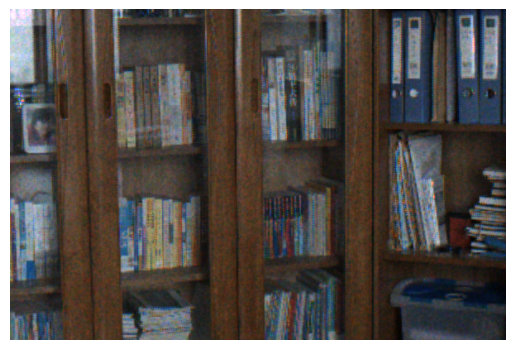

In [266]:
# Display module
temp = Rgb_images.permute(1, 2, 0)
temp = temp.numpy()
# Display the numpy array as an image
plt.axis("off")
plt.imshow(temp)
plt.show()

In [215]:
def SpaceToDepth_fact2(x):
  # From here - https://discuss.pytorch.org/t/is-there-any-layer-like-tensorflows-space-to-depth-function/3487/14
  bs = 2
  N, C, H, W = x.size()
  x = x.view(N, C, H // bs, bs, W // bs, bs)      # (N, C, H//bs, bs, W//bs, bs)
  x = x.permute(0, 3, 5, 1, 2, 4).contiguous()    # (N, bs, bs, C, H//bs, W//bs)
  x = x.view(N, C * (bs ** 2), H // bs, W // bs)  # (N, C*bs^2, H//bs, W//bs)
  return x
def DepthToSpace_fact2(x):
  # From here - https://discuss.pytorch.org/t/is-there-any-layer-like-tensorflows-space-to-depth-function/3487/14
  bs = 2
  N, C, H, W = x.size()
  x = x.view(N, bs, bs, C // (bs ** 2), H, W)     # (N, bs, bs, C//bs^2, H, W)
  x = x.permute(0, 3, 4, 1, 5, 2).contiguous()    # (N, C//bs^2, H, bs, W, bs)
  x = x.view(N, C // (bs ** 2), H * bs, W * bs)   # (N, C//bs^2, H * bs, W * bs)
  return x


In [261]:
def Demosaic(bayer_images):
  def SpaceToDepth_fact2(x):
    # From here - https://discuss.pytorch.org/t/is-there-any-layer-like-tensorflows-space-to-depth-function/3487/14
    bs = 2
    N, C, H, W = x.size()
    x = x.view(N, C, H // bs, bs, W // bs, bs)      # (N, C, H//bs, bs, W//bs, bs)
    x = x.permute(0, 3, 5, 1, 2, 4).contiguous()    # (N, bs, bs, C, H//bs, W//bs)
    x = x.view(N, C * (bs ** 2), H // bs, W // bs)  # (N, C*bs^2, H//bs, W//bs)
    return x
  def DepthToSpace_fact2(x):
    # From here - https://discuss.pytorch.org/t/is-there-any-layer-like-tensorflows-space-to-depth-function/3487/14
    bs = 2
    N, C, H, W = x.size()
    x = x.view(N, bs, bs, C // (bs ** 2), H, W)     # (N, bs, bs, C//bs^2, H, W)
    x = x.permute(0, 3, 4, 1, 5, 2).contiguous()    # (N, C//bs^2, H, bs, W, bs)
    x = x.view(N, C // (bs ** 2), H * bs, W * bs)   # (N, C//bs^2, H * bs, W * bs)
    return x

  """Bilinearly demosaics a batch of RGGB Bayer images."""
  bayer_images = bayer_images.permute(0, 2, 3, 1) # Permute the image tensor to BxHxWxC format from BxCxHxW format

  shape = bayer_images.size()
  shape = [shape[1] * 2, shape[2] * 2]

  red = bayer_images[Ellipsis, 0:1]
  upsamplebyX = nn.Upsample(size=shape, mode='bilinear', align_corners=False)
  red = upsamplebyX(red.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)

  green_red = bayer_images[Ellipsis, 1:2]
  green_red = torch.flip(green_red, dims=[1]) # Flip left-right
  green_red = upsamplebyX(green_red.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
  green_red = torch.flip(green_red, dims=[1]) # Flip left-right
  green_red = SpaceToDepth_fact2(green_red.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)

  green_blue = bayer_images[Ellipsis, 2:3]
  green_blue = torch.flip(green_blue, dims=[0]) # Flip up-down
  green_blue = upsamplebyX(green_blue.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
  green_blue = torch.flip(green_blue, dims=[0]) # Flip up-down
  green_blue = SpaceToDepth_fact2(green_blue.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)

  green_at_red = (green_red[Ellipsis, 0] + green_blue[Ellipsis, 0]) / 2
  green_at_green_red = green_red[Ellipsis, 1]
  green_at_green_blue = green_blue[Ellipsis, 2]
  green_at_blue = (green_red[Ellipsis, 3] + green_blue[Ellipsis, 3]) / 2

  green_planes = [
      green_at_red, green_at_green_red, green_at_green_blue, green_at_blue
  ]
  green = DepthToSpace_fact2(torch.stack(green_planes, dim=-1).permute(0, 3, 1, 2)).permute(0, 2, 3, 1)

  blue = bayer_images[Ellipsis, 3:4]
  blue = torch.flip(torch.flip(blue, dims=[1]), dims=[0])
  blue = upsamplebyX(blue.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
  blue = torch.flip(torch.flip(blue, dims=[1]), dims=[0])
  print("blue shape", blue.shape)

  rgb_images = torch.cat([red, green, blue], dim=-1)
  rgb_images = rgb_images.permute(0, 3, 1, 2)  # Re-Permute the tensor back to BxCxHxW format
  print(rgb_images.shape)
  return rgb_images


In [263]:
image_2 = Demosaic(bayer_images.permute(0, 3, 1, 2))

blue shape torch.Size([1, 400, 600, 1])
torch.Size([1, 3, 400, 600])


In [264]:
image_2.shape

torch.Size([1, 3, 400, 600])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


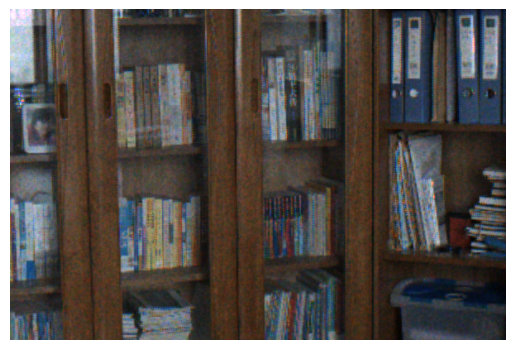

In [267]:
image_2 = image_2[0]
# Display module
temp = Rgb_images.permute(1, 2, 0)
temp = temp.numpy()
# Display the numpy array as an image
plt.axis("off")
plt.imshow(temp)
plt.show()

In [ ]:
# (400, 600, 3), for opencv 
# (3, 400, 600)  for tensor

In [279]:
image_2.shape

torch.Size([3, 400, 600])

Now working of apply ccms, here i am using the variable image_3 for the experiments 

In [331]:
ccms = metadata['cam2rgb']
image_3 = image_2 

In [332]:
shape = image_3.size()
image_3 = image_3.view(1, shape[0], shape[1], shape[2])

In [333]:
image_3.shape

torch.Size([1, 3, 400, 600])

In [334]:
image_3 = image_3.permute(0, 2, 3, 1)

In [335]:
image_3 = image_3[:, :, :, None, :]

In [336]:
image_3.shape

torch.Size([1, 400, 600, 1, 3])

In [337]:
ccms.shape

torch.Size([3, 3])

In [295]:
ccms = ccms[None, None, None, :, :]

In [298]:
images.shape

torch.Size([1, 3, 400, 1, 600])

In [296]:
ccms.shape

torch.Size([1, 1, 1, 3, 3])

In [338]:
def apply_ccm_unprocess(image, ccm):
  """Applies a color correction matrix."""
  image = image.permute(1, 2, 0) # Permute the image tensor to HxWxC format from CxHxW format
  shape = image.size()
  image = torch.reshape(image, [-1, 3])
  image = torch.tensordot(image, ccm, dims=[[-1], [-1]])
  out   = torch.reshape(image, shape)
  out   = out.permute(2, 0, 1) # Re-Permute the tensor back to CxHxW format
  return out

In [341]:
image_3 = apply_ccm_unprocess(image_2, metadata['cam2rgb'])

In [342]:
image_3.shape

torch.Size([3, 400, 600])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


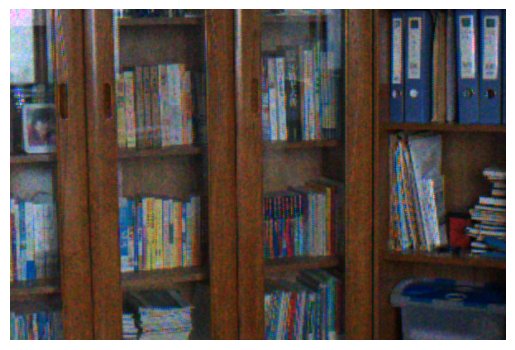

In [340]:
# Display module
temp = image_3.permute(1, 2, 0)
temp = temp.numpy()
# Display the numpy array as an image
plt.axis("off")
plt.imshow(temp)
plt.show()

In [343]:
image_3.shape

torch.Size([3, 400, 600])

In [344]:
image_4 = gamma_compression(image_3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


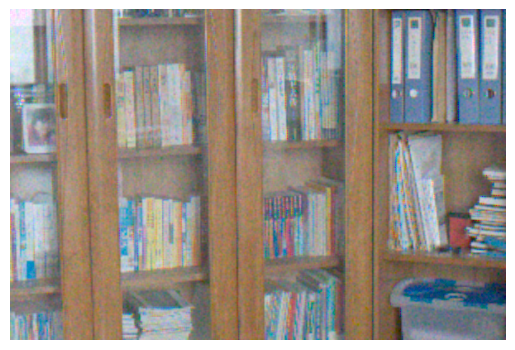

In [345]:
# Display module
temp = image_4.permute(1, 2, 0)
temp = temp.numpy()
# Display the numpy array as an image
plt.axis("off")
plt.imshow(temp)
plt.show()

Upscale experiments 

In [109]:
# define a tensor and view as a 3D tensor
x = torch.tensor([[1., 2., 3.],
				[4., 5., 6.],
				])

In [110]:
x.size()

torch.Size([2, 3])

In [111]:
X = x.view(1,1,2,3)

In [112]:
X.shape

torch.Size([1, 1, 2, 3])

In [113]:
X

tensor([[[[1., 2., 3.],
          [4., 5., 6.]]]])

In [114]:
X = X.squeeze(0)

In [115]:
X

tensor([[[1., 2., 3.],
         [4., 5., 6.]]])

In [299]:
# Declare a tensor
a = torch.tensor([[1, 2], [3, 4], [5, 6]])

# Sum over dimension 1 (rows)
d = torch.sum(a, dim=1)

# Print the result
print(d)


tensor([ 3,  7, 11])


In [300]:
# Sum over dimension 1 (rows)
e = torch.sum(a, dim=-1)

# Print the result
print(e)

tensor([ 3,  7, 11])


In [302]:
import torch

# Declare a 3D tensor
a = torch.tensor([[[1, 2], [3, 4]], [[5, 6], [7, 8]]])

# Sum over the last dimension
b = torch.sum(a, dim=-1)

# Print the shape and the values of b
print(b.shape)
print(b)

torch.Size([2, 2])
tensor([[ 3,  7],
        [11, 15]])


In [303]:
b.shape

torch.Size([2, 2])